In [29]:
%%bash
# 查看数据文件目录  list datalab files
ls datalab/25331/

# # 查看当前kernel下已安装的包  list packages
# !pip list --format=columns

# # 查看个人永久空间文件  list files in your permanent storage
# !ls /home/tianchi/myspace/

date_label.csv


## 方案说明
本方案采用长短期记忆神经网络(LSTM)来对2013年7月至2014年8月的申购和赎回总量进行建模分析，并对2014年9月每一天的申购和赎回总量进行预测。
关于RNNs系列原理可以参考[博客](https://blog.csdn.net/roger_royer/article/details/90552633), 数据存放在[我的数据集](https://tianchi.aliyun.com/notebook-ai/home?spm=5176.12281897.0.0.4ab339a9HjDw5t#datasetLabId=25331&operaType=2)。本方案对申购和赎回单独建模，但是两个模型的参数除了epoch其它都一样。

In [10]:
# 数据查看
import pandas
data = pandas.read_csv('datalab/25331/date_label.csv', engine='python') 

In [11]:
data

,report_date,total_purchase_amt,total_redeem_amt
0,20130701,32488348,5525022
1,20130702,29037390,2554548
2,20130703,27270770,5953867
3,20130704,18321185,6410729
4,20130705,11648749,2763587
5,20130706,36751272,1616635
6,20130707,8962232,3982735
7,20130708,57258266,8347729
8,20130709,26798941,3473059
9,20130710,30696506,2597169


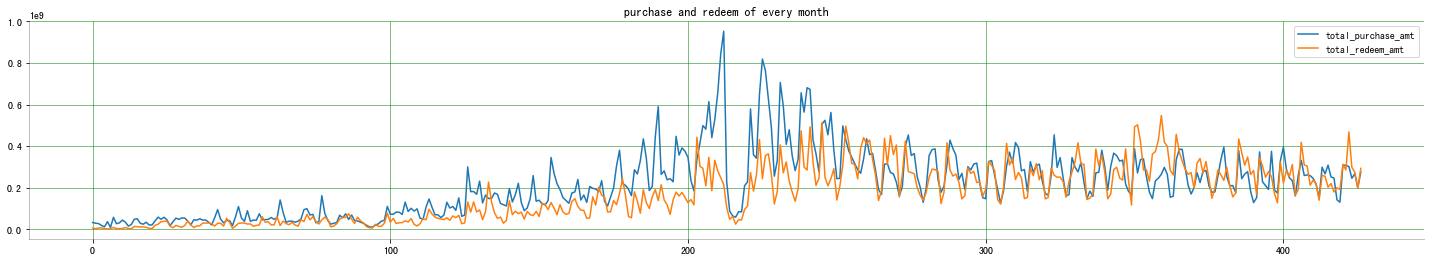

In [27]:
# 可视化展示

import pandas
import matplotlib.pyplot as plt
data = pandas.read_csv('datalab/25331/date_label.csv', engine='python') 

plt.rcParams['figure.figsize'] = (25, 4.0)  # set figure size

data[['total_purchase_amt', 'total_redeem_amt']].plot()
plt.grid(True, linestyle="-", color="green", linewidth="0.5")
plt.legend()
plt.title('purchase and redeem of every month')

plt.gca().spines["top"].set_alpha(0.0)
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)
plt.gca().spines["left"].set_alpha(0.3)

plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 1, 64)             26880     
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 30)                990       
Total params: 41,342
Trainable params: 41,342
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
 - 1s - loss: 0.0648
Epoch 2/150
 - 0s - loss: 0.0233
Epoch 3/150
 - 0s - loss: 0.0175
Epoch 4/150
 - 0s - loss: 0.0169
Epoch 5/150
 - 0s - loss: 0.0165
Epoch 6/150
 - 0s - loss: 0.0161
Epoch 7/150
 - 0s - loss: 0.0158
Epoch 8/150
 - 0s - loss: 0.0153
Epoch 

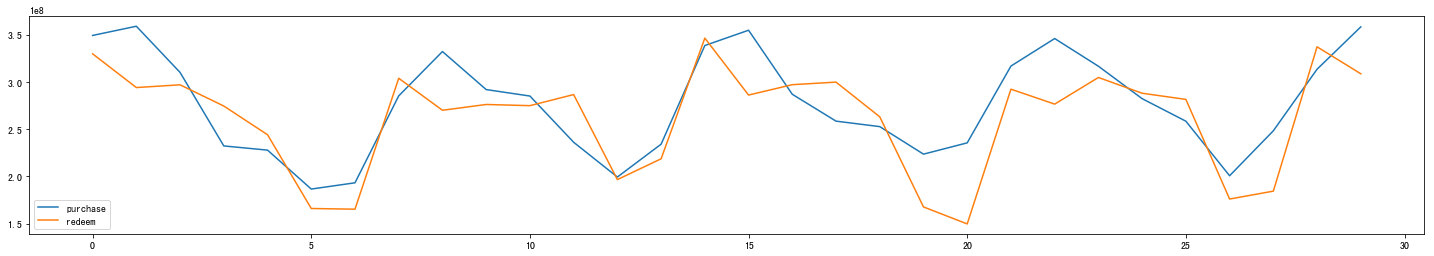

In [28]:

# -*- coding:utf-8 -*-

"""
reference:https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
Note:
1.LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing.
2.The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].
"""

import math
import numpy
import pandas
from keras.layers import LSTM, RNN, GRU, SimpleRNN
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import os

numpy.random.seed(2019)


class RNNModel(object):
    def __init__(self, look_back=1, epochs_purchase=20, epochs_redeem=40, batch_size=1, verbose=2, patience=10, store_result=False):
        self.look_back = look_back
        self.epochs_purchase = epochs_purchase
        self.epochs_redeem = epochs_redeem
        self.batch_size = batch_size
        self.verbose = verbose
        self.store_result = store_result
        self.patience = patience
        self.purchase = pandas.read_csv('datalab/25331/date_label.csv', usecols=[1], engine='python') 
        self.redeem = pandas.read_csv('datalab/25331/date_label.csv', usecols=[2], engine='python')
        
    def access_data(self, data_frame):
        # load the data set
        data_set = data_frame.values
        data_set = data_set.astype('float32')

        # LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing.
        scaler = MinMaxScaler(feature_range=(0, 1))
        data_set = scaler.fit_transform(data_set)

        # reshape into X=t and Y=t+1
        train_x, train_y, test = self.create_data_set(data_set)

        # reshape input to be [samples, time steps, features]
        train_x = numpy.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
        return train_x, train_y, test, scaler

    # convert an array of values into a data set matrix
    def create_data_set(self, data_set):
        data_x, data_y = [], []
        for i in range(len(data_set)-self.look_back - 30):
            a = data_set[i:(i + self.look_back), 0]
            data_x.append(a)
            data_y.append(list(data_set[i + self.look_back: i + self.look_back + 30, 0]))
        # print(numpy.array(data_y).shape)
        return numpy.array(data_x), numpy.array(data_y), data_set[-self.look_back:, 0].reshape(1, 1, self.look_back)

    def rnn_model(self, train_x, train_y, epochs):
        model = Sequential()
        model.add(LSTM(64, input_shape=(1, self.look_back), return_sequences=True))
        model.add(LSTM(32, return_sequences=False))
        model.add(Dense(32))
        model.add(Dense(30))
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.summary()
        early_stopping = EarlyStopping('loss', patience=self.patience)
        history = model.fit(train_x, train_y, epochs=epochs, batch_size=self.batch_size, verbose=self.verbose, callbacks=[early_stopping])
        return model

    def predict(self, model, data):
        prediction = model.predict(data)
        return prediction

    def plot_show(self, predict):
        predict = predict[['purchase', 'redeem']]
        predict.plot()
        plt.show()

    def run(self):
        purchase_train_x, purchase_train_y, purchase_test, purchase_scaler = self.access_data(self.purchase)
        redeem_train_x, redeem_train_y, redeem_test, redeem_scaler = self.access_data(self.redeem)

        purchase_model = self.rnn_model(purchase_train_x, purchase_train_y, self.epochs_purchase)
        redeem_model = self.rnn_model(redeem_train_x, redeem_train_y, self.epochs_redeem)

        purchase_predict = self.predict(purchase_model, purchase_test)
        redeem_predict = self.predict(redeem_model, redeem_test)

        test_user = pandas.DataFrame({'report_date': [20140900 + i for i in range(1, 31)]})

        purchase = purchase_scaler.inverse_transform(purchase_predict).reshape(30, 1)
        redeem = redeem_scaler.inverse_transform(redeem_predict).reshape(30, 1)

        test_user['purchase'] = purchase
        test_user['redeem'] = redeem
        print(test_user)

        """Store submit file"""
        if self.store_result is True:
            test_user.to_csv('submit_lstm.csv', encoding='utf-8', index=None, header=None)
            
        """plot result picture"""
        self.plot_show(test_user)
        
if __name__ == '__main__':
    initiation = RNNModel(look_back=40, epochs_purchase=150, epochs_redeem=230, batch_size=16, verbose=2, patience=50, store_result=False)
    initiation.run()


## 结果分析
- 线上得分：120+
- 该模型对参数极为敏感，尤其是look_back, epochs_purchase, epochs_redeem这三个。
- 模型设计也比较简单，可以对网络结构和上面三个参数进行一个微调，结果应该能上130。
- 本方案没有对数据进行一个预处理，其实这个数据是很不稳定的，建议可以对数据进行一个平滑或者差分处理。
- 该题目还有其它提分点，比如节假日处理(中秋节)、模型融合等。
- 本方案只起一个抛砖引玉的作用，如果有说的不好或者不对的地方欢迎大家指正！